In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn import svm

from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

cvxopt_solvers.options['show_progress'] = False

# Defining Kernels

In [2]:

def distance_matrix(A, B, squared=False):
   
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*A.dot(B.T)

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

def linear_K(A,B):
    return np.dot(A , B.T) * 1.
   
def RBF_K(A,B,RBF_sig=1):

    D = distance_matrix(A,B)
    return np.exp(-D/2/RBF_sig**2)



# Data Gen

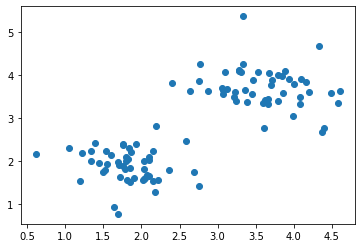

In [84]:
N = 100
X = np.zeros((N,2))
c1, c2 = [1,1], [-1,-1]
sigma = 0.2
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

X = X + 3*np.array(c1)
X = X/np.std(X,axis=0)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)

plt.scatter(X[:,0],X[:,1])

# SVM implementation

In [106]:
def SVM(K, Y, C=1.0):
    N = K.shape[0]
    G = np.vstack([np.eye(N, N), -np.eye(N, N)])

    # C = 1/2/N/lmbda

    h = np.concatenate([np.repeat(C, N), np.repeat(0, N)]).astype(np.double)
    label = -1.0 * np.logical_not(Y) + 1.0 * Y
    P = np.diag(label) @ K @ np.diag(label)
    np.testing.assert_array_equal(P, P.transpose())

    A = np.matrix(label)
    b = np.zeros(1)
    q = -np.ones((N, 1))

    P = cvxopt_matrix(P)
    G = cvxopt_matrix(G)
    h = cvxopt_matrix(h)
    b = cvxopt_matrix(b)
    A = cvxopt_matrix(A)
    q = cvxopt_matrix(q)

    # print(f'{P=}')
    # print(f'{q=}')
    # print(f'{G=}')
    # print(f'{h=}')
    # print(f'{A=}')
    # print(f'{b=}')

    sol = cvxopt_solvers.qp(
        P=P,
        q=q,
        G=G,
        h=h,
        A=A,
        b=b,
    )
    alphas = np.array(sol["x"]).flatten()

    S = 1e-4 < alphas
    M = np.logical_and(S, (alphas < C - 1e-4))

    b = np.mean(
        [label[n] - (alphas * label).dot(K[n, :]) for n in np.where(M)[0]]
    )
    # print(S,np.diag(label)@K@np.diag(label).dot(alphas).flatten())
    return alphas, b


def pred(gram, Y, alphas, b):
    label = -1.0 * np.logical_not(Y) + 1.0 * Y
    return gram.dot(alphas * label) + b


C = 1

get_K = RBF_K
K = get_K(X, X)
gram = get_K(X, X)

alphas, b = SVM(K, Y, C=C)

S = (alphas > float(1e-4)).flatten()
# # b = y[S] - np.dot(X[S], w)
print("intercept : ", b)
print("Indices of support vectors = ", np.where(S))
print("Alphas = ", alphas[alphas > 1e-4])

print("Support vectors = ", X[S])
print("Number of support vectors for each class = ", np.sum(S))

label = -1.0 * np.logical_not(Y) + 1.0 * Y
alphas = np.squeeze(alphas)

y = pred(gram, Y, alphas, b)

# plt.plot(y)
# plt.plot(label)


intercept :  0.03474486026189053
Indices of support vectors =  (array([  2,   4,   5,   6,   7,   8,  11,  13,  14,  27,  30,  34,  35,
        36,  38,  39,  40,  41,  53,  65,  66,  68,  71,  73,  74,  81,
        85,  87,  91,  95,  97,  98,  99, 104, 105, 106, 107, 109, 112,
       120, 123, 126, 128, 130, 132, 135, 138, 140, 141, 145, 146, 151,
       154, 159, 160, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172,
       173, 175, 180, 182, 183, 184, 188, 189, 190, 196, 197, 198, 199,
       206, 209, 210, 211, 218, 221, 229, 238, 241, 242, 244, 246, 250,
       253, 256, 259, 261, 263, 264, 267, 269, 272, 273, 274, 276, 278,
       279, 280, 284, 286, 288, 290, 292, 293]),)
Alphas =  [7.52372961e-02 9.99999993e-01 9.99999999e-01 9.99999999e-01
 9.99999996e-01 7.90581449e-02 9.99999993e-01 4.51303555e-01
 9.99999995e-01 9.99999997e-01 9.99999998e-01 9.99999995e-01
 9.99999988e-01 9.99999999e-01 9.99999996e-01 9.99999990e-01
 3.21549538e-01 5.81483958e-01 9.99999998e-01 9.30824586

# comparison with scikit

b =  [-0.01139007]
Indices of support vectors =  [154 162 163 165 166 167 169 171 173 175 182 183 188 189 190 197 199 203
 206 209 210 225 229 238 241 242 244 246 250 256 259 261 263 267 269 273
 274 278 279 284 286 290 292 293   4   5   6   7  11  13  14  27  30  34
  35  36  38  39  40  42  53  66  68  71  73  74  80  81  87  91  95  98
  99 104 105 106 107 109 112 120 123 126 128 130 135 141 145 146]
Support vectors =  [[ 1.06274451  2.41858138]
 [ 1.34186777  1.71860379]
 [ 1.03809491  2.48205126]
 [ 2.3669308   2.04529228]
 [ 2.33907855  0.82282945]
 [ 2.66734782  1.78287394]
 [ 3.54150419  4.53549079]
 [ 1.56564532  2.90644334]
 [ 2.23824426  1.21411941]
 [ 4.0903284   3.0153004 ]
 [ 3.10597727  1.08258107]
 [ 1.70095055  1.8387398 ]
 [ 2.61103391  0.92577997]
 [ 2.8205645   1.15249957]
 [ 2.34734007  1.79687316]
 [ 1.48744019  2.74360985]
 [ 1.56435167  2.94564941]
 [ 2.33079388  2.12791857]
 [ 4.02781295  3.7155673 ]
 [ 1.79684488  2.22383964]
 [ 2.0474042   2.06709135]
 [ 1.65

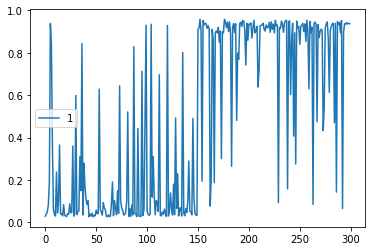

In [107]:
# for C in np.logspace(-2,2,5):

clf = svm.SVC(probability=True,C=C,kernel='rbf')
clf.fit(X, Y)
y = clf.predict_proba(X)[:,0]

plt.plot(y,label = C)
plt.legend()

print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))


In [108]:
def pred(gram,Y,alphas,b, use_b = True):
    label = -1.*np.logical_not(Y)+1.*Y
    if use_b:
        return gram.dot(alphas*label) + b 
    else:
        return gram.dot(alphas*label)

def run_SVM_get_pred(K, gram,Y,C = 1, X= None, Z = None, use_b = True):

    alphas, b = SVM(K,Y,C=C)
    alphas = np.squeeze(alphas)

    return pred(gram,Y,alphas,b,use_b)


# Varying regularization param C

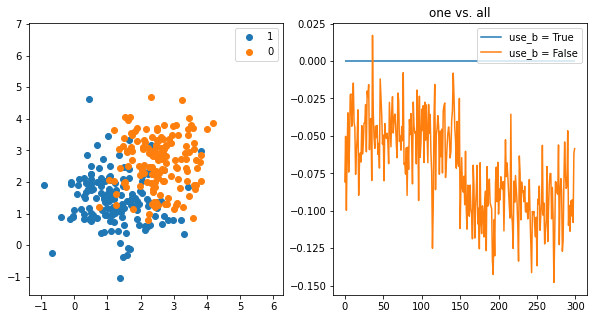

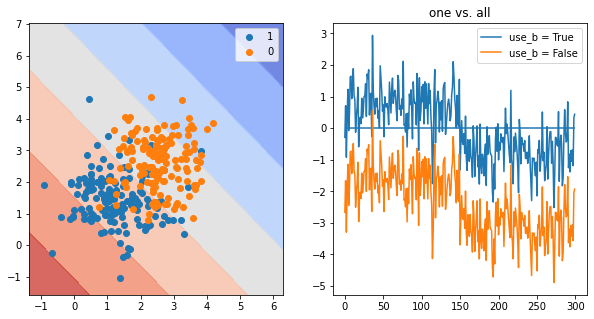

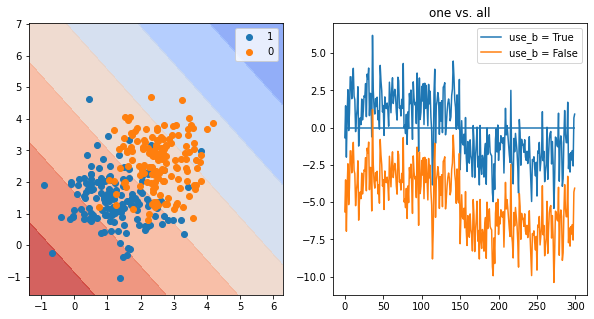

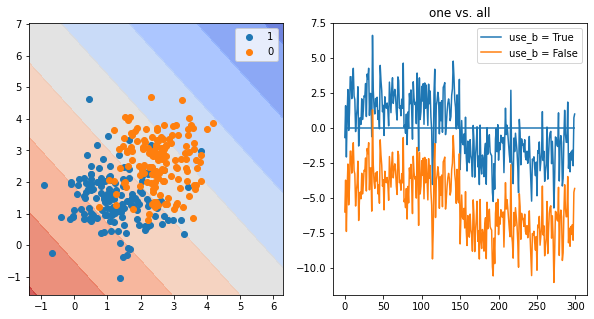

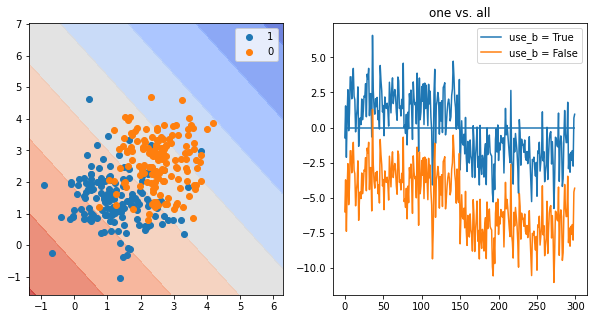

In [109]:

def run_SVM_and_plot_contours(X,Y, clf = run_SVM_get_pred, n_map = 100, C = 1, get_K = linear_K):

    x_min, x_max = np.min(X[:,0])*1.5,np.max(X[:,0])*1.5
    y_min, y_max = np.min(X[:,1])*1.5,np.max(X[:,1])*1.5

    x_r = np.linspace(x_min,x_max,n_map)
    y_r = np.linspace(y_min,y_max,n_map)
    x_r, y_r = np.meshgrid(x_r,y_r)
    x_r_, y_r_ = np.ndarray.flatten(x_r),np.ndarray.flatten( y_r)
    Z = np.vstack((x_r_,y_r_)).transpose()

    K = get_K(X,X)
    gram = get_K(Z,X)

    y = clf(K,gram,Y,C = C,X = X,Z = Z)

    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.contourf(x_r, y_r, y.reshape(n_map,n_map), cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[Y==1,0],X[Y==1,1],label = '1')
    plt.scatter(X[Y==0,0],X[Y==0,1],label = '0')
    plt.legend()    
    plt.subplot(122)

    K = get_K(X,X)
    gram = get_K(X,X)

    y = clf(K,gram,Y,C = C,X = X,Z = X,use_b=True)
    plt.plot(y, label = 'use_b = True')

    y = clf(K,gram,Y,C = C,X = X,Z = X,use_b=False)
    plt.plot(y, label = 'use_b = False')

    plt.hlines(0,0,len(y))
    plt.legend()

# generate data
N = 300
X = np.zeros((N,2))
c1, c2 = [1,1], [-1,-1]
sigma = 1.5
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

# X = X-np.mean(X,axis=0)

X = X + 3*np.array(c1)
X = X/np.std(X,axis=0)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)

get_K = linear_K
for C in np.logspace(-4,4,5):
    run_SVM_and_plot_contours(X,Y,C= C, get_K = get_K)
    plt.title('one vs. all')
    plt.show()


# comparison with scikit
Scikit Rbf uses a method to automatically calibrate the RBF variance term

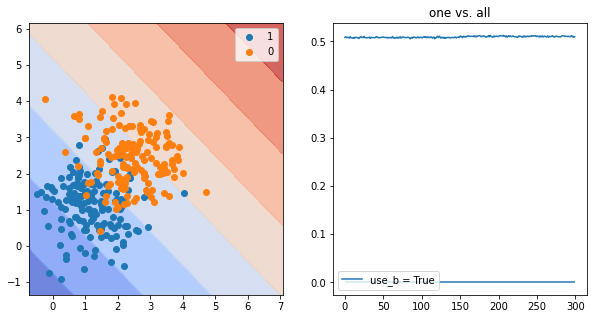

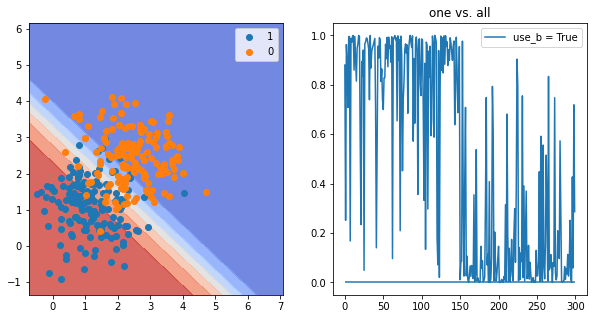

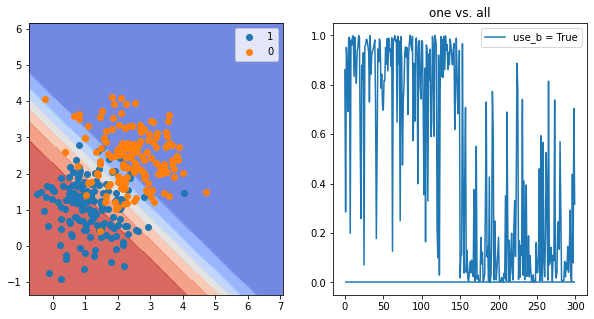

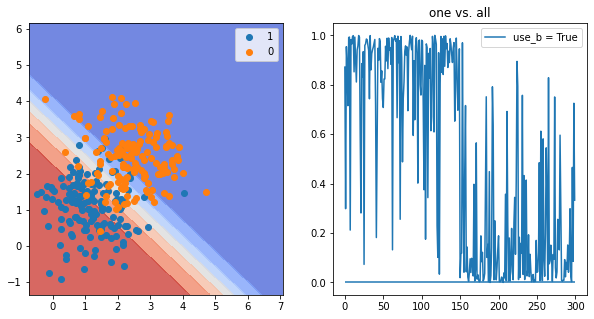

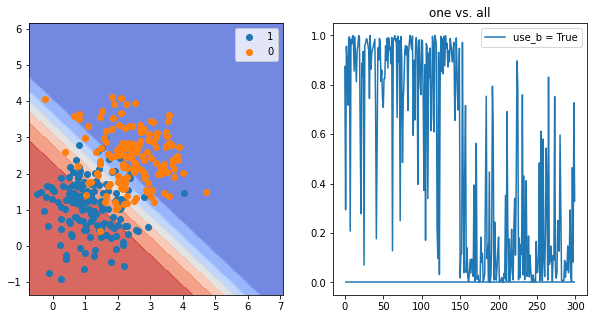

In [47]:

def scikit_SVM(K,gram,Y,C = 1,X=None,Z=None,kernel = 'linear'):

    clf = svm.SVC(probability=True,C=C,kernel=kernel)
    clf.fit(X, np.logical_not(Y))
    y = clf.predict_proba(Z)
    return y[:,0]


for C in np.logspace(-4,4,5):
    run_SVM_and_plot_contours(X,Y,clf = scikit_SVM,C= C)
    plt.title('one vs. all')
    plt.show()



# C and $\sigma$ grid search over test data

(500, 2)


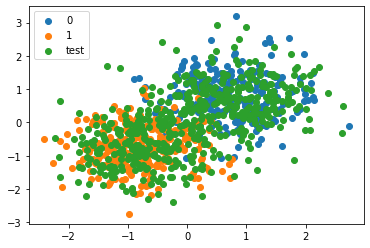

In [68]:
N = 1000
X = np.zeros((N,2))
print(np.random.multivariate_normal(c1,np.eye(2,2),N//2).shape)
mu = 2
c1, c2 = [mu,mu], [-mu,-mu]
sigma = 3
X[N//2:] = np.random.multivariate_normal(c1,sigma*np.eye(2,2),N//2)
X[:N//2] = np.random.multivariate_normal(c2,sigma*np.eye(2,2),N//2)

X = X-np.mean(X,axis=0)
X = X/np.std(X,axis=0)

Y = [True]*(N//2)+[False]*(N//2)
Y = np.array(Y)
idx = np.random.choice(range(N),N,replace=False)

split = int(N//2)
X, Y = X[idx], Y[idx]
X_train = X[:split]
Y_train = Y[:split]
X_test = X[split:]
Y_test = Y[split:]

plt.scatter(X_train[Y_train==0,0],X_train[Y_train==0,1],label = '0')
plt.scatter(X_train[Y_train==1,0],X_train[Y_train==1,1],label = '1')
plt.scatter(X_test[:,0],X_test[:,1],label = 'test')
plt.legend()

In [69]:
from sklearn.metrics import log_loss

def scikit_SVM(K,gram,Y,C = 1,X=None,Z=None,kernel = 'rbf'):

    clf = svm.SVC(probability=True,C=C,kernel=kernel)
    clf.fit(X, np.logical_not(Y))
    y = clf.predict(Z)
    return np.logical_not(y)


max acc scikit :  0.944


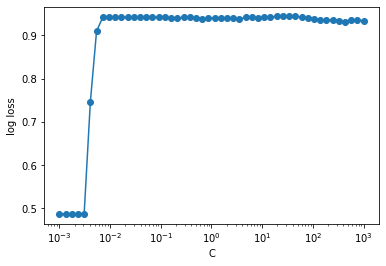

In [70]:
res = []

clf = scikit_SVM

C_list = np.logspace(-3,3,50)
sig = 1e-1
def RBF_K(A,B,RBF_sig=sig):

    D = distance_matrix(A,B)
    return np.exp(-D/2/RBF_sig**2)

get_K = RBF_K
K = get_K(X_train,X_train)
gram = get_K(X_test,X_train)


for C in C_list:
    y = clf(K,gram,Y_train, C=C,X = X_train,Z = X_test)
    # res.append(log_loss(Y_test,np.sign(y)>0))

    # res.append(log_loss(Y_test,y>0))
    res.append(np.mean(np.logical_not(np.logical_xor(Y_test,y>0))))

plt.plot(C_list,res,'o-')
plt.xscale('log')
plt.ylabel('log loss')
plt.xlabel('C')
print('max acc scikit : ',np.max(res))

max acc ours :  0.942


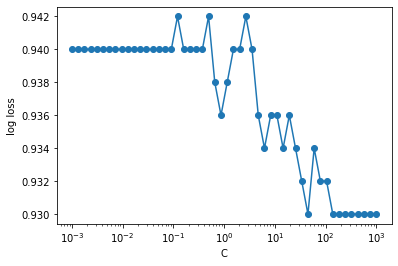

In [71]:
res = []
clf = run_SVM_get_pred

C_list = np.logspace(-3,3,50)
sig = 1
def RBF_K(A,B,RBF_sig=sig):

    D = distance_matrix(A,B)
    return np.exp(-D/2/RBF_sig**2)

get_K = RBF_K
K = get_K(X_train,X_train)
gram = get_K(X_test,X_train)


for C in C_list:
    y = clf(K,gram,Y_train, C=C,X = X_train,Z = X_test)
    # res.append(log_loss(Y_test,np.sign(y)>0))

    # res.append(log_loss(Y_test,y>0))
    res.append(np.mean(np.logical_not(np.logical_xor(Y_test,y>0))))

plt.plot(C_list,res,'o-')
plt.xscale('log')
plt.ylabel('log loss')
plt.xlabel('C')
print('max acc ours : ',np.max(res))

max acc ours :  0.942


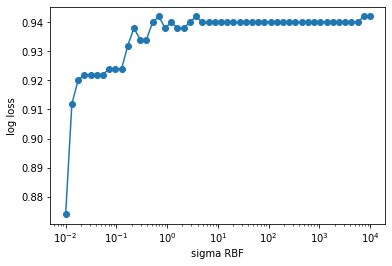

In [72]:
res = []
clf = run_SVM_get_pred
C = 1
sig_list = np.logspace(-2,4,50)
for sig in sig_list:

    def RBF_K(A,B,RBF_sig=sig):

        D = distance_matrix(A,B)
        return np.exp(-D/2/RBF_sig**2)
    get_K = RBF_K

    K = get_K(X_train,X_train)
    gram = get_K(X_test,X_train)

    y = clf(K,gram,Y_train, C=C,X = X_train,Z = X_test)
    # res.append(log_loss(Y_test,np.sign(y)>0))

    # res.append(log_loss(Y_test,y>0))
    res.append(np.mean(np.logical_not(np.logical_xor(Y_test,y>0))))
plt.plot(sig_list,res,'o-')
plt.xscale('log')
plt.ylabel('log loss')
plt.xlabel('sigma RBF')

print('max acc ours : ',np.max(res))